# Contextual Bandit Simulation Tutorial

This notebook demonstrates how to use a contextual bandit problem specification to model choice data in a multidimensional bandit task (for a review of this type of task, see [this](https://www.cell.com/trends/cognitive-sciences/fulltext/S1364-6613(19)30036-1) paper). We will:

1. Set up a 2 dimensions × 3 features contextual bandit task
2. Simulate an agent without attention learning to make choices
3. Visualize learning curves
4. Modify the model to include an implementation of attention
5. Compare task performance between the two models


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add libraries to path
import sys
import os
sys.path.append(os.getcwd() + '/libraries/')

# Import custom libraries
from World import World
from FeatureRL import Agent as FRL
from plotting import plot_behavior, plot_attention_conditions

/Users/rosskempner/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Step 1: Define the World (Task Environment)

We'll create a contextual bandit task with:
- **2 dimensions** (e.g., shape and color)
- **3 features per dimension** (e.g., circle/square/triangle, red/blue/green)
- **Reward probabilities**: 0.8 for target feature, 0.2 for non-target features

In [2]:
# Set world properties
n_dims = 2
n_feats_per_dim = 3
world_h = 0  # Rate of target change (0 = stable target)
world_p_high = 0.8  # Reward probability when target feature is present
world_p_low = 0.2   # Reward probability when target feature is absent
outcome = 1  # Binary outcome value

# Create the world
world = World(n_dims, n_feats_per_dim, world_h, world_p_high, world_p_low, outcome)

print(f"World created with {n_dims} dimensions and {n_feats_per_dim} features per dimension")
print(f"Total features: {world.n_feats}")
print(f"Target feature: {world.target}")
print(f"Reward probabilities: {world.p_high} (target) vs {world.p_low} (non-target)")

World created with 2 dimensions and 3 features per dimension
Total features: 6
Target feature: 2
Reward probabilities: 0.8 (target) vs 0.2 (non-target)


### Visualize the Reward Function

Let's visualize the reward structure to understand which features lead to high vs low reward probabilities.

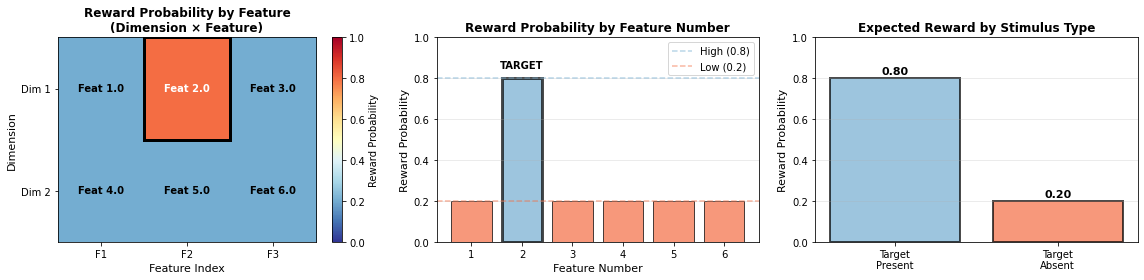


=== Reward Function Summary ===
Target feature: 2
Reward probability when target is present: 0.8
Reward probability when target is absent: 0.2
Expected reward difference: 0.60


In [3]:
# Visualize the reward function using the World class method
fig, axes = world.plot_reward_function()
plt.show()

# Print summary
print(f"\n=== Reward Function Summary ===")
print(f"Target feature: {world.target}")
print(f"Reward probability when target is present: {world.p_high}")
print(f"Reward probability when target is absent: {world.p_low}")
print(f"Expected reward difference: {world.p_high - world.p_low:.2f}")

## Step 2: Define the Agent (Learning Model)

We'll create a Feature Reinforcement Learning (FRL) agent with parameters for learning and decision-making.

In [4]:
# Set agent parameters
agent_params = {
    'learning_rate': 0.2,       # How quickly the agent updates feature values
    'decay_rate': 0.0,          # How quickly unchosen features decay 
    'beta_value_choice': 20,    # Inverse temperature for choice (higher = more deterministic)
    'phi': 0.5,                 # Attention parameter
    'w_init': 0,                # Initial feature weights   
    'beta_value_gaze': 0,       # Not used for choice-only simulation
    'beta_center_dim': 0,       # Not used for choice-only simulation
    'beta_center_feat': 0,      # Not used for choice-only simulation
    'decay_target': 0,          # Not used
    'precision': 0              # Not used for choice-only simulation           
}

# Create the agent
agent = FRL(world, agent_params)

print("Agent created with parameters:")
print(f"  Learning rate: {agent_params['learning_rate']}")
print(f"  Decay rate: {agent_params['decay_rate']}")
print(f"  Choice temperature (beta): {agent_params['beta_value_choice']}")
print(f"  Attention parameter (phi): {agent_params['phi']}")

Agent created with parameters:
  Learning rate: 0.2
  Decay rate: 0.0
  Choice temperature (beta): 20
  Attention parameter (phi): 0.5


## Step 3: Simulate Choice Data

We'll simulate one game using the library's `simulate_choice_task` method. On each trial:
1. Three stimuli (options) are presented
2. The agent evaluates each option based on learned feature values
3. The agent chooses using a softmax decision rule
4. The world provides feedback (reward or no reward)
5. The agent updates its feature values based on the outcome

In [5]:
# Simulate one game 
n_trials = 18  
print(f"Simulating one game ({n_trials} trials)...")
results = agent.simulate_choice_task(world, n_trials=n_trials)
print("Simulation complete!")
print(f"\nTarget feature: {results['target']}")
print(f"Game accuracy: {np.mean(results['correct']):.2%}")
print(f"Game reward rate: {np.mean(results['outcomes']):.2%}")

Simulating one game (18 trials)...
Simulation complete!

Target feature: 2
Game accuracy: 16.67%
Game reward rate: 22.22%


## Step 4: Plot Behavior

We'll visualize how the agent's behavior changes over time.

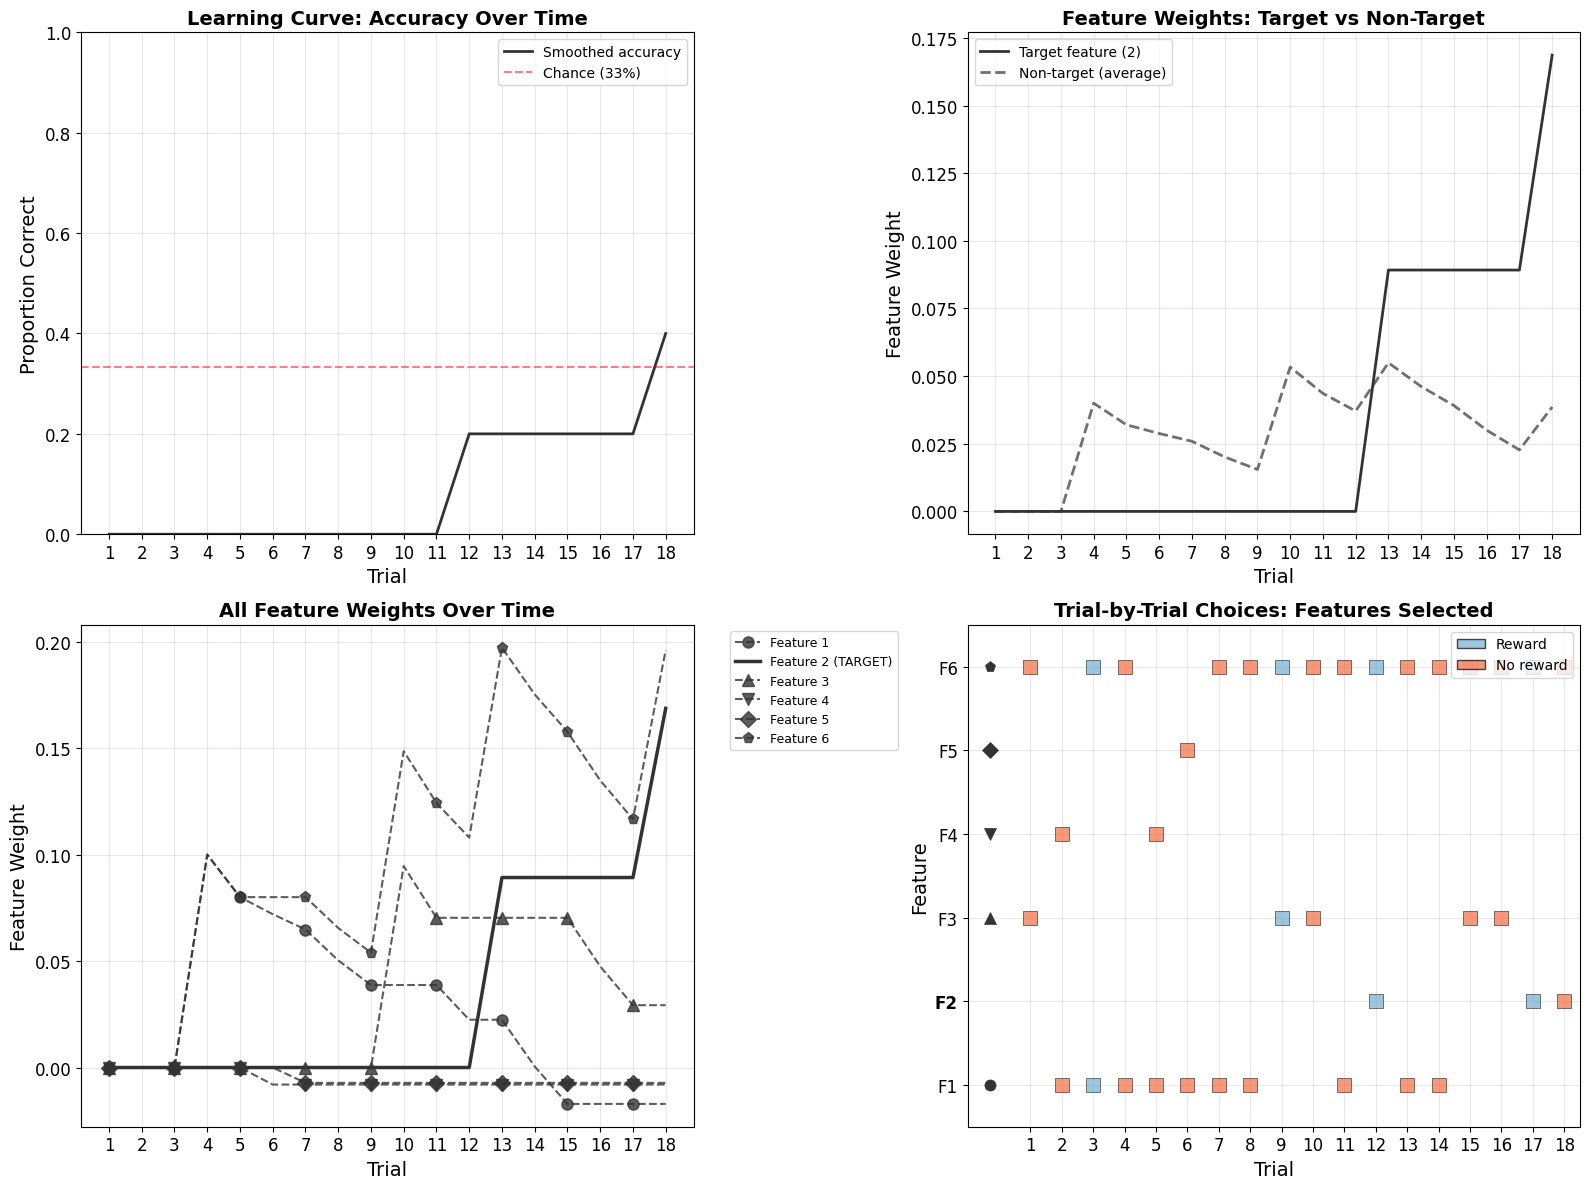


=== Summary Statistics ===
Overall accuracy: 16.67%
Early accuracy (trials 1-5): 0.00%
Late accuracy (trials 16-20): 66.67%

Overall reward rate: 22.22%
Early reward rate (trials 1-5): 20.00%
Late reward rate (trials 16-20): 33.33%

Target feature: 2
Final target feature weight: 0.169
Final average non-target weight: 0.039


In [6]:
# Prepare variables for summary statistics
feature_weights = results['feature_weights']
target_feat_idx = results['target'] - 1  # Convert to 0-indexed
non_target_mask = np.arange(world.n_feats) != target_feat_idx

# Plot behavior using shared plotting function
plot_behavior(results, world, n_trials)

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"Overall accuracy: {np.mean(results['correct']):.2%}")
print(f"Early accuracy (trials 1-5): {np.mean(results['correct'][:5]):.2%}")
print(f"Late accuracy (trials 16-20): {np.mean(results['correct'][15:]):.2%}")
print(f"\nOverall reward rate: {np.mean(results['outcomes']):.2%}")
print(f"Early reward rate (trials 1-5): {np.mean(results['outcomes'][:5]):.2%}")
print(f"Late reward rate (trials 16-20): {np.mean(results['outcomes'][15:]):.2%}")
print(f"\nTarget feature: {results['target']}")
print(f"Final target feature weight: {feature_weights[-1, target_feat_idx]:.3f}")
print(f"Final average non-target weight: {np.mean(feature_weights[-1, non_target_mask]):.3f}")

## Step 5: Exercises — Study Attention in Simulation

In this series of exercises, you will study the performance of an agent using congruent/incongruent/neutral attention in simulation.

You are allowed to use AI tools for coding or drafting explanations.
However, you are responsible for ensuring that every explanation matches your actual implementation.

You will be graded primarily on your mechanistic understanding, not on code length or performance alone.

### Exercise 1 

Starting from the provided RL codebase (no attention):

Explain why, after changing exactly one of the following, adding attention is plausibly useful:
- the task structure
- the feature representation  
- the learning signal

Consider a specific failure mode of the original agent that attention could address.

---

### Exercise 2 

Before running your attention-augmented agent:

State one concrete prediction about how learning with attention will differ from learning without attention. Explain why you expect this difference, given your task and where attention acts. Your prediction must be testable with a plot.

**Examples predictions:**
- Learning is slower early but more stable later
- Congruent attention leads to faster learning than incongruent attention
- Performance differences between attention conditions are largest in early trials

---

### Exercise 3

Starting from the provided code structure below, you will write new code to implement the attention comparison study. The purpose of the study is to compare agent performance across three attention conditions:
- **Congruent attention**: More attention to the dimension containing the target feature
- **Neutral attention**: Equal attention to both dimensions
- **Incongruent attention**: Less attention to the dimension containing the target feature

Fill in the code sections marked with `# TODO:` comments below. For each section you complete:

1. **Write the code** to implement the functionality
2. **Add a comment block** immediately below your code with:
   ```python
   # CHANGE N: <mechanism name>
   # [2-3 sentences explaining what this code does and why it implements the mechanism]
   # [Reference specific variables/operations, e.g., phi, target_dim, agent_params['phi']]
   # If I removed or replaced this line, the agent would...
   ```

**Requirements:**
- Reference actual variables and operations (not just high-level descriptions)
- Explanation should match your code exactly
- Include the "If I removed..." sentence for each change

In [8]:
# TODO 1: Determine which dimension contains the target feature
# Features 1 to n_feats_per_dim are in dimension 1
# Features (n_feats_per_dim + 1) to (2 * n_feats_per_dim) are in dimension 2
# Hint: Use integer division (//) to find which dimension the target belongs to
# The result should be 0-indexed (0 = dimension 1, 1 = dimension 2)
# Write your code here:
target_dim = None  # YOUR CODE HERE: Calculate which dimension contains the target feature
print(f"Target feature: {world.target} (in dimension {target_dim + 1})")

# TODO 2: Set up attention parameters for the three conditions
# Hint: check the code in the provided codebase to see how phi is used
# Write your code here:
phi_congruent = None  # YOUR CODE HERE 
phi_incongruent = None  # YOUR CODE HERE 
phi_neutral = None  # YOUR CODE HERE

print(f"\nCongruent case: phi = {phi_congruent} (more attention to target dimension {target_dim + 1})")
print(f"Neutral case: phi = {phi_neutral} (equal attention to both dimensions)")
print(f"Incongruent case: phi = {phi_incongruent} (less attention to target dimension {target_dim + 1})")

# Set number of agents to simulate
n_agents = 500

# Case 1: Congruent attention
print(f"\n=== Case 1: Congruent Attention ===")
print(f"Simulating {n_agents} agents with phi = {phi_congruent}...")

all_accuracy_congruent = []

# TODO 3: Simulate multiple agents with congruent attention
# For each agent:
#   1. Set agent_params['phi'] to phi_congruent
#   2. Create a new agent with these parameters
#   3. Run simulate_choice_task() to get results
#   4. Append results['correct'] to all_accuracy_congruent
#   5. Optionally print progress every 100 agents
# Write your code here:
for agent_idx in range(n_agents):
    # YOUR CODE HERE
    pass

# Case 2: Neutral attention (equal)
print(f"\n=== Case 2: Neutral Attention (Equal) ===")
print(f"Simulating {n_agents} agents with phi = {phi_neutral}...")

all_accuracy_neutral = []

# TODO 4: Simulate multiple agents with neutral attention
# Follow the same pattern as TODO 3, but use phi_neutral
# Write your code here:
for agent_idx in range(n_agents):
    # YOUR CODE HERE
    pass

# Case 3: Incongruent attention
print(f"\n=== Case 3: Incongruent Attention ===")
print(f"Simulating {n_agents} agents with phi = {phi_incongruent}...")

all_accuracy_incongruent = []

# TODO 5: Simulate multiple agents with incongruent attention
# Follow the same pattern as TODO 3, but use phi_incongruent
# Write your code here:
for agent_idx in range(n_agents):
    # YOUR CODE HERE
    pass

print("\nAll simulations complete!")

# TODO 6: Calculate average accuracy and standard error of the mean (SEM) for each condition
# For each condition (congruent, neutral, incongruent):
#   - Calculate mean accuracy across agents (axis=0 gives mean across agents for each trial)
#   - Calculate SEM: std / sqrt(n_agents)
# Hint: Use np.mean() and np.std() with appropriate axis parameter
# Write your code here:
avg_accuracy_congruent = None  # YOUR CODE HERE
sem_accuracy_congruent = None  # YOUR CODE HERE

avg_accuracy_neutral = None  # YOUR CODE HERE
sem_accuracy_neutral = None  # YOUR CODE HERE

avg_accuracy_incongruent = None  # YOUR CODE HERE
sem_accuracy_incongruent = None  # YOUR CODE HERE

# Print summary statistics
print(f"\n=== Average Performance Across {n_agents} Agents ===")
print(f"\nCongruent (phi={phi_congruent}):")
print(f"  Overall accuracy: {np.mean(avg_accuracy_congruent):.2%} ± {np.std(np.mean(all_accuracy_congruent, axis=1)):.2%}")
print(f"  Early accuracy (trials 1-5): {np.mean(avg_accuracy_congruent[:5]):.2%}")
print(f"  Late accuracy (trials 16-20): {np.mean(avg_accuracy_congruent[15:]):.2%}")

print(f"\nNeutral (phi={phi_neutral}):")
print(f"  Overall accuracy: {np.mean(avg_accuracy_neutral):.2%} ± {np.std(np.mean(all_accuracy_neutral, axis=1)):.2%}")
print(f"  Early accuracy (trials 1-5): {np.mean(avg_accuracy_neutral[:5]):.2%}")
print(f"  Late accuracy (trials 16-20): {np.mean(avg_accuracy_neutral[15:]):.2%}")

print(f"\nIncongruent (phi={phi_incongruent}):")
print(f"  Overall accuracy: {np.mean(avg_accuracy_incongruent):.2%} ± {np.std(np.mean(all_accuracy_incongruent, axis=1)):.2%}")
print(f"  Early accuracy (trials 1-5): {np.mean(avg_accuracy_incongruent[:5]):.2%}")
print(f"  Late accuracy (trials 16-20): {np.mean(avg_accuracy_incongruent[15:]):.2%}")

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

### Visualize and Analyze Results

Plot the learning curves for all three attention conditions and compare them to your prediction from Exercise 2.

**Questions to consider:**
- Does the data match your prediction? If not, what might explain the discrepancy?
- How do the three conditions differ in early vs. late trials?
- What does this tell you about how attention affects learning in this task?

In [ ]:
plot_attention_conditions(
    avg_accuracy_congruent,
    sem_accuracy_congruent,
    avg_accuracy_neutral,
    sem_accuracy_neutral,
    avg_accuracy_incongruent,
    sem_accuracy_incongruent,
    n_trials,
    n_agents,
    phi_congruent,
    phi_neutral,
    phi_incongruent,
    target_dim,
)